In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
from statsbombpy import sb
import os
import pandas as pd

In [2]:
# Open the data and assign it to df
parser = Sbopen()
df = parser.match(competition_id=43, season_id=106)

In [3]:
print (df.columns)

Index(['match_id', 'match_date', 'kick_off', 'home_score', 'away_score',
       'match_status', 'match_status_360', 'last_updated', 'last_updated_360',
       'match_week', 'competition_id', 'country_name', 'competition_name',
       'season_id', 'season_name', 'home_team_id', 'home_team_name',
       'home_team_gender', 'home_team_group', 'home_team_country_id',
       'home_team_country_name', 'home_team_managers_id',
       'home_team_managers_name', 'home_team_managers_nickname',
       'home_team_managers_dob', 'home_team_managers_country_id',
       'home_team_managers_country_name', 'away_team_id', 'away_team_name',
       'away_team_gender', 'away_team_group', 'away_team_country_id',
       'away_team_country_name', 'away_team_managers_id',
       'away_team_managers_name', 'away_team_managers_nickname',
       'away_team_managers_dob', 'away_team_managers_country_id',
       'away_team_managers_country_name', 'metadata_data_version',
       'metadata_shot_fidelity_version', 'm

In [4]:
team = "Croatia"

# Get list of games by our team, either home or away
match_ids = df.loc[(df["home_team_name"] == team) | (df["away_team_name"] == team)]["match_id"].tolist()

# Calculate number of games
no_games = len(match_ids)

In [5]:
#declare an empty dataframe
danger_passes = pd.DataFrame()
for idx in match_ids:
    #open the event data from this game
    df = parser.event(idx)[0]
    for period in [1, 2]:
        #keep only accurate passes by England that were not set pieces in this period
        mask_pass = (df.player_id == 5463) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        #keep only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_id"]]
        #keep only Shots by England in this period
        mask_shot = (df.player_id == 5463) & (df.type_name == "Shot") & (df.period == period)
        #keep only necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]
        #convert time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15
        #find starts of the window
        shot_start = shot_times - shot_window
        #condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        #convert to seconds
        pass_times = passes['minute']*60+passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

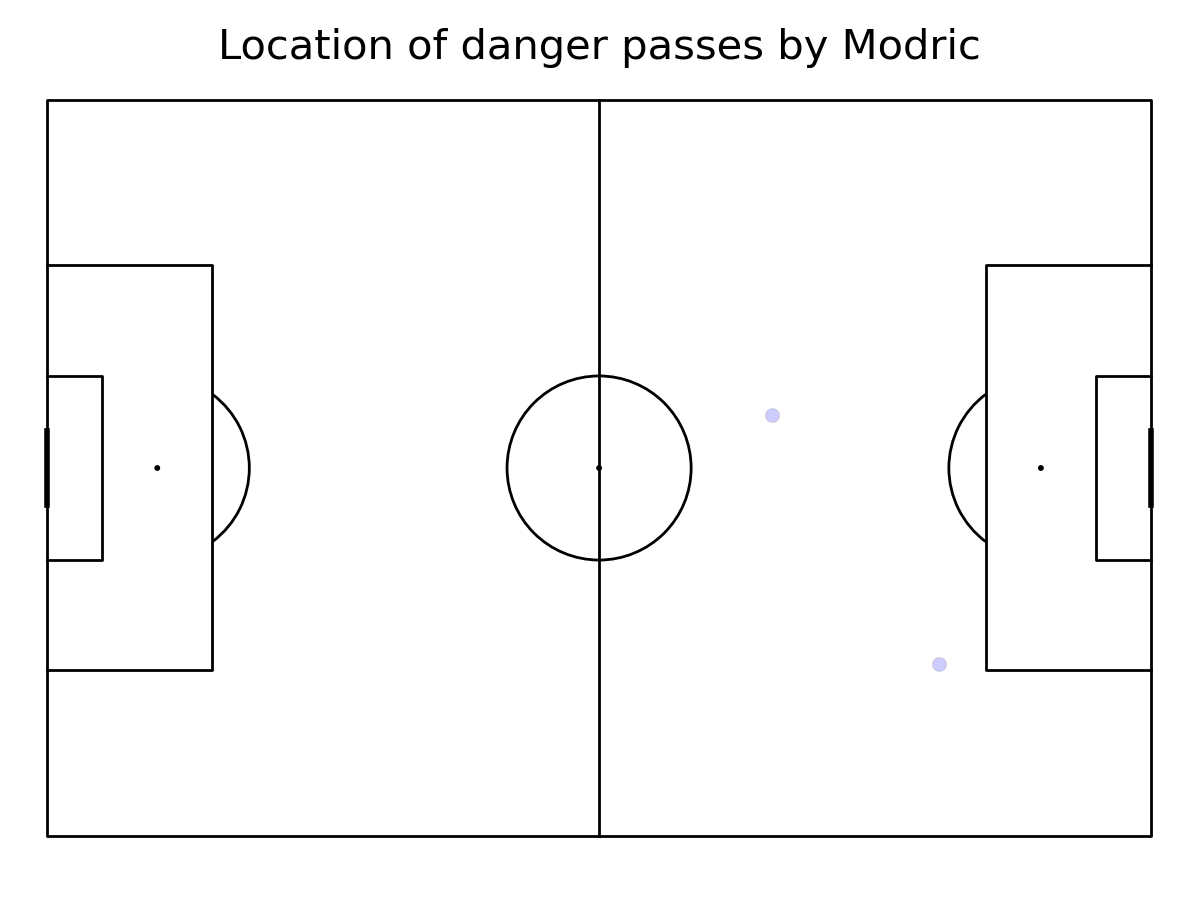

In [7]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
#uncomment it to plot arrows
#pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by Modric', fontsize = 30)
plt.show()

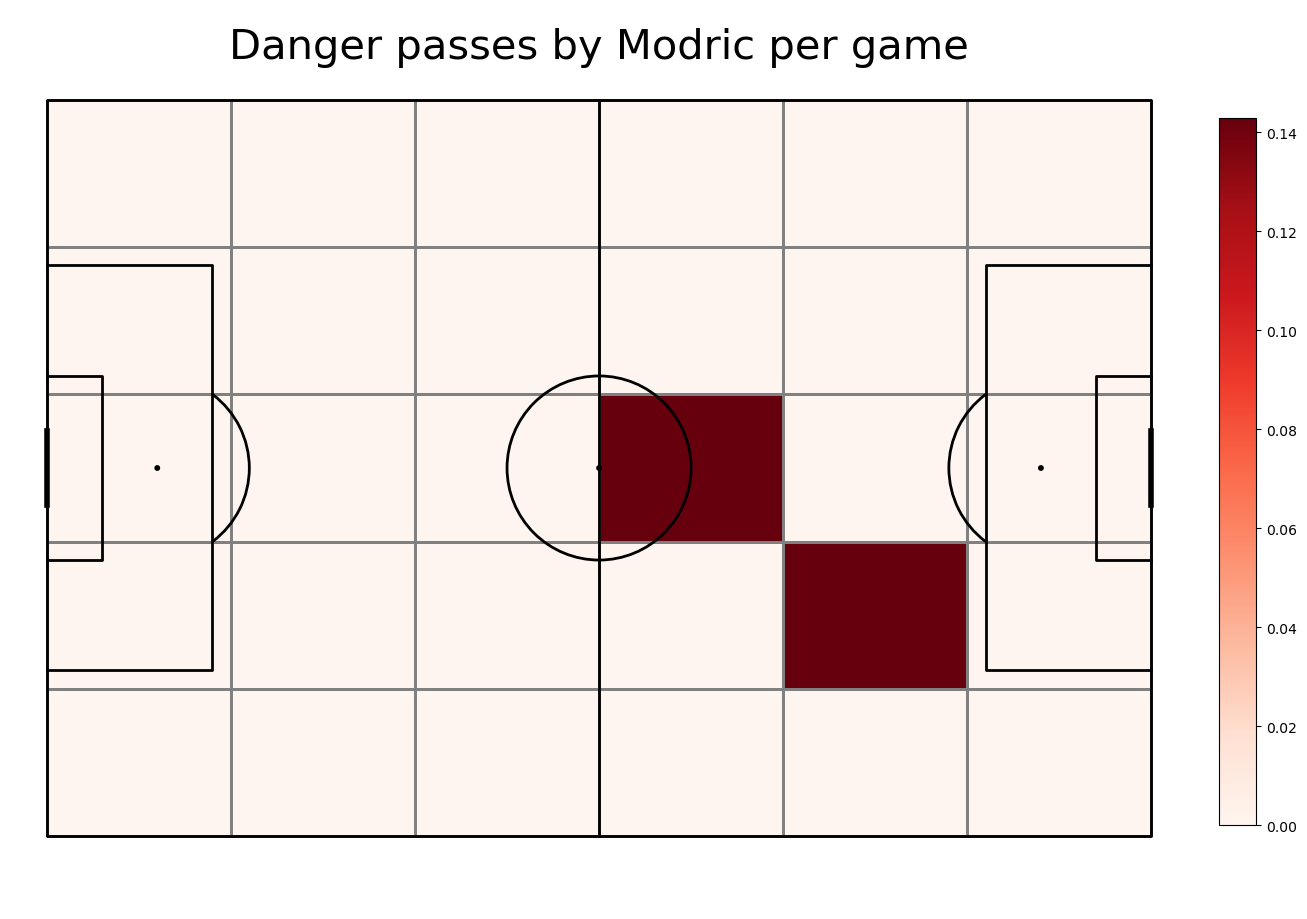

In [9]:
#plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by Modric' + " per game", fontsize = 30)
plt.show()

In [10]:
df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'end_x', 'end_y', 'body_part_id', 'body_part_name',
       'sub_type_id', 'sub_type_name', 'x', 'y', 'under_pressure',
       'outcome_id', 'outcome_name', 'aerial_won', 'off_camera', 'out',
       'dribble_overrun', 'pass_cross', 'pass_switch', 'counterpress',
       'shot_statsbomb_xg', 'technique_id', 'technique_name',
       'goalkeeper_position_id', 'goalkeeper_position_name',
       'foul_won_defensive', 'pass_assisted_shot_id', 'pass_shot_assist',
       'dribble_nutmeg', 'shot_key_pass_id', 'end_z',
       'ball_rec

In [11]:
print(match_ids)

[3869684, 3869519, 3869420, 3869219, 3857296, 3857281, 3857277]


In [12]:
print(no_games)

7
